In [2]:
import pandas as pd
from sentence_transformers import SentenceTransformer
import numpy as np
from tqdm import tqdm_notebook as tqdm
import torch.nn.functional as F
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn import metrics
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
%matplotlib inline

# Recipe for Success
(Based entirely on Karpathy "A Recipe for Training Neural Networks")

## Not so Subtle Reminders
1. Remember that neural nets aren't as simple to train as they are made to seem. Hidden behind the simple lines of these frameworks are many layers of complexity. Make a concious effort to develop a deep understanding on what's going on behind the scenes. It will help immensely when things begin to break.
2. Neural networks have an uncanny ability to fail *silently*. In programming, many problems are avoided using thorough unit testing and if not you may get lucky and the things you miss might end up throwing an exception anyway. Neural networks are unique in that they may not show any signs of failure, but in reality it's working worse than it should be due to something such as: you forgot to flip your labels when you left-right flipped the image during data augmentation. 

## Key Principles
1. Don't be a hero. Start **simple** and **gradually** build up complexity.
2. Be patient.
3. Pay extra attention to detail. Test and double check everything.

## Basic Steps
1. Develop a deep understanding of your dataset.
2. Set up **simple** end-to-end training/evaluation skeleton to get dumb baselines
3. Now you want to begin iterating on a good model.
    - First get a model large enough that it can overfit (i.e. focus on training loss)
    - If you've done step 2 *correctly* and you are still unable to reach a low error rate with any model at all then that may
      indicate an issue/bug/misconfiguration.
4. At this point you have a large model that is fitting at least the training set. Now it's time to regularize it and give up some train loss to gain some val loss.
5. Now you begin exploring a wide model space to achieve the lowest val loss you can reach.
6. Once you have an idea of the best kind of architecture/hyper-parameters there's still some areas to squeeze out a few extra percent in accuracy
    - Ensembles
    - Leave it training. Networks keep training for an unintuitively long time, you may be surprised what happens if you give it enough time

### Explore the Data

In [3]:
data = pd.read_csv("IMDB.csv")

In [4]:
# Get rid of unnecessary columns
data = data.drop(['Unnamed: 0', 'index', 'tconst','language', 'types', 'attributes', 'isOriginalTitle', 'isAdult'], axis=1)

In [5]:
data.shape

(7850, 13)

In [6]:
data.head()

,titleType,primaryTitle,originalTitle,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes,ordering,title,region,Description
0,movie,The Silence of the Lambs,The Silence of the Lambs,1991,\N,118,"Crime,Drama,Thriller",8.6,1473918,50,The Silence of the Lambs,US,"Jodie Foster stars as Clarice Starling, a top ..."
1,movie,Terminator 2: Judgment Day,Terminator 2: Judgment Day,1991,\N,137,"Action,Sci-Fi",8.6,1128166,17,Terminator 2: Judgment Day,US,"In this sequel set eleven years after ""The Ter..."
2,movie,The Lion King,The Lion King,1994,\N,88,"Adventure,Animation,Drama",8.5,1090882,18,The Lion King 3D,US,This Disney animated feature follows the adven...
3,movie,Pulp Fiction,Pulp Fiction,1994,\N,154,"Crime,Drama",8.9,2118762,22,Pulp Fiction,US,Vincent Vega (John Travolta) and Jules Winnfie...
4,movie,The Shawshank Redemption,The Shawshank Redemption,1994,\N,142,Drama,9.3,2759621,2,The Shawshank Redemption,US,Andy Dufresne (Tim Robbins) is sentenced to tw...


In [26]:
# Use Sentence Transformer from hugging face to retrieve word embedddings for descriptions
all_desc = data['Description'].astype(str).tolist()
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-V2')

# Use tqdm to track the progress of encoding
with tqdm(total=len(all_desc), desc="Encoding sentences") as pbar:
    # Encode each sentence and update the progress bar
    sentence_embeddings = []
    for desc in all_desc:
        embedding = model.encode(desc)
        sentence_embeddings.append(embedding)
        pbar.update(1)

C:\Users\Stephen\AppData\Local\Temp\ipykernel_19500\133283522.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  with tqdm(total=len(all_desc), desc="Encoding sentences") as pbar:


Encoding sentences:   0%|          | 0/7850 [00:00<?, ?it/s]

In [7]:
# Save embeddings in torch tensor for later use
# embeddings = torch.tensor(sentence_embeddings)
# embeddings.shape

# Or.. Restore embeddings from pytorch tensor
embeddings = torch.load("embeddings.pt")

In [8]:
# Calculate cosine similarity of description of Shawshank Redemption with every other movie/show desc in the list
# Note: Picks up similarities to other movies/shows involving prison
sim = F.cosine_similarity(embeddings[4].unsqueeze(0), embeddings, dim=1)
sim_pairs = list(enumerate(sim))
sorted_sim_pairs = sorted(sim_pairs, key=lambda x:x[1], reverse=True)
sorted_sim_pairs[:10]

[(4, tensor(1.)),
 (69, tensor(0.5307)),
 (4727, tensor(0.5159)),
 (917, tensor(0.5102)),
 (753, tensor(0.5099)),
 (4441, tensor(0.4832)),
 (2520, tensor(0.4769)),
 (4434, tensor(0.4757)),
 (1753, tensor(0.4671)),
 (2408, tensor(0.4619))]

In [9]:
# Print the top 10 ratings of all movies/shows
ratings = list(enumerate(data['averageRating']))
sorted_ratings = sorted(ratings, key=lambda x:x[1], reverse=True)
print(sorted_ratings[:10])

[(132, 9.5), (1536, 9.5), (4764, 9.5), (5399, 9.5), (99, 9.4), (523, 9.4), (1424, 9.4), (5304, 9.4), (4, 9.3), (779, 9.3)]


### Narrowing in on a genre classification model based on movie/show description

In [10]:
# Circling back from my personal classifications section below to clean up the duplicates issues 
remove_idx_lst_tmp = data[data['primaryTitle'].duplicated(keep=False)].index.tolist()

# remove indices where descriptions are too short (fewer than 60 characters)
remove_idx_lst_tmp += data[data['Description'].str.len() < 60].index.tolist()

# Use pandas get_dummies to create multi-hot encoding
# super cool function
multi_hot = data['genres'].str.get_dummies(sep=',')

# Remove all genres with less than 150 movies/tv-shows within them
genre_counts_mask = multi_hot.sum() > 150
genres_filtered_df = multi_hot.loc[:,genre_counts_mask]

# Remove any of the rows that have no genre
print("Original shape:", multi_hot.shape)
remove_idx_lst_tmp += genres_filtered_df[genres_filtered_df.sum(axis=1) == 0].index.tolist()
# Added the line below to avoid deleting an index multiple times which could have been a pretty nasty bug, but because of how 
# I deleted things this didn't end up being an issue. The pandas df didn't reset indices so once an index is gotten it no
# no longer exists, it's not like everything above it shifts down one. And for the pytorch mask it would just mean a certain
# index got set equal to zero multiple times. 
remove_idx_lst = list(set(remove_idx_lst_tmp))
filtered = genres_filtered_df.drop(remove_idx_lst_tmp) # CHANGE
print("Filtered shape:", filtered.shape)

#Convert to torch tensor
multi_hot_tensor = torch.tensor(filtered.values, dtype=torch.float32)

# Removing matching indexes from embeddings tensor. Torch tensors can't actually delete so need to create a mask and index
mask = torch.ones(embeddings.shape[0], dtype=torch.bool)
mask[remove_idx_lst_tmp] = 0 # CHANGE

new_embeddings = embeddings[mask]
print("Embeddings original shape:", embeddings.shape)
print("Filtered embeddings shape:", new_embeddings.shape)

Original shape: (7850, 27)
Filtered shape: (7041, 19)
Embeddings original shape: torch.Size([7850, 384])
Filtered embeddings shape: torch.Size([7041, 384])


In [11]:
# Stats on word embeddings
print("Average value of every element:", new_embeddings.mean(axis=1).mean().item())
print("Average value of min elements:", new_embeddings.min(axis=1).values.mean().item())
print("Average value of max elements:", new_embeddings.max(axis=1).values.mean().item())

Average value of every element: -0.00040699203964322805
Average value of min elements: -0.1526476889848709
Average value of max elements: 0.15412428975105286


In [12]:
# Counts per genre
filtered.sum()

Action         1463
Adventure       998
Animation       620
Biography       647
Comedy         2107
Crime          1502
Documentary     575
Drama          4675
Family          225
Fantasy         355
History         405
Horror          324
Music           238
Mystery         718
Romance         925
Sci-Fi          297
Sport           159
Thriller        793
War             151
dtype: int64

In [13]:
# Clearly still a pretty unbalanced dataset, let's get an idea of how many genres the content usually has
filtered.sum(axis=1).mean()

2.43956824314728

In [14]:
# Only ~1100 have a single genre
(filtered.sum(axis=1) == 1).sum()

1066

In [15]:
# Minimum of a single genre, max of 3 genres
print(filtered.sum(axis=1).min())
print(filtered.sum(axis=1).max())

1
3


In [16]:
# Figure I might as well test my own skills on predicting genres from descriptions
# I'll do 20 and see what kind of accuracy I'll get. For the most part I'll just try to predict 2 because that's the average
# maybe if I'm feeling confident I'll throw in a third genre.

# Reference of possible genres
# ['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime',
#        'Documentary', 'Drama', 'Family', 'Fantasy', 'Game-Show', 'History',
#        'Horror', 'Music', 'Musical', 'Mystery', 'News', 'Reality-TV',
#        'Romance', 'Sci-Fi', 'Short', 'Sport', 'Talk-Show', 'Thriller', 'War',
#        'Western', '\N']

# data (7850, 13)

# Select 30 random indices
np.random.seed(4859)
idxs = np.random.randint(0, high=7851, size=30)[:20]

count = 1
for desc in data.iloc[idxs, -1]:
    print(count)
    print(desc)
    print()
    count += 1

1
An anthology of sinister stories told by revered horror creators.

2
Food critic Steve Coogan and traveling companion Rob Brydon trade delicious barbs and clever remarks as they tour various eateries in northern England.

3
Renowned Dragon Knight Davion becomes embroiled in events much larger than he could have ever imagined.

4
Some British retirees (Judi Dench, Maggie Smith, Bill Nighy) decide to outsource their retirement to exotic -- and less expensive -- India. Lured by advertisements for the newly restored Marigold Hotel and imagining a life of leisure in lush surroundings, they arrive and find that the Marigold is actually a shell of its former self. Though their new home is not quite what they had imagined, the retirees find that life and love can begin again when they let go of their pasts.

5
A suburban father of three girls tries to reform an undisciplined and fatherless boy by teaching him what it really means to be a man.

6
A young woman searches for a way to escape fro

In [18]:
#### My classifications
mine = [["Horror", "Thriller"],
["Reality-TV", "Documentary"],
["Fantasy", "Action"],
["Drama", "Romance"],
["Family", "Drama"],
["Fantasy", "Animation"],
["Drama"],
["Mystery", "Crime"],
["Crime", "Thriller"],
["Documentary"],
["Drama"],
["Romance", "Drama"],
["Comedy", "Drama"],
["Action", "Adventure"],
["Drama", "Comedy"],
["Crime", "Drama"],
["Adventure", "Action"],
["History"],
["Action", "Adventure"],
["Drama", "Action"]]

In [19]:
tru = data.iloc[idxs[:20], 6].tolist()
ct = 0

for item in tru:
    tru[ct] = item.split(',')
    ct += 1

# List of genres
gens = ['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Family', 'Fantasy', 'Game-Show', 'History',
       'Horror', 'Music', 'Musical', 'Mystery', 'News', 'Reality-TV',
       'Romance', 'Sci-Fi', 'Short', 'Sport', 'Talk-Show', 'Thriller', 'War',
       'Western']

# Mapping genres to indexes
stoi = {s:i for i,s in enumerate(gens)}

# Create multi-hot arrays for my classifications and the ground truth's
mine_map = []
tru_map = []

for lst in mine:
    tmp = np.zeros((25), dtype=int)
    for item in lst:
        idx = stoi[item]
        tmp[idx] = 1
    mine_map.append(tmp)
    
for lst in tru:
    tmp = np.zeros((25), dtype=int)
    for item in lst:
        idx = stoi[item]
        tmp[idx] = 1
    tru_map.append(tmp)

# While I was doing my classifications I came across an error with the dataset from kaggle
# All the details can be found here: 
# https://www.kaggle.com/datasets/ishikajohari/imdb-data-with-descriptions/discussion/443834
# TLDR: Due to the fact that the dataset was created by pulling some information from RottenTomatoes and the Descriptions
# from IMDb there were errors with the wrong descriptions being pulled for certain movies/shows because they had the same
# title as another movie/show. i.e. Two very different movies both with the title "The Trip"

# I'm popping index 1 because there's an issue with how they created the dataset and the data for that index is wrong
mine_map.pop(1)
tru_map.pop(1)

array([1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0])

In [20]:
# Metrics for my classifications (YIKES haha)
acc = metrics.accuracy_score(tru_map, mine_map)
p = metrics.precision_score(tru_map, mine_map, average='samples')
r = metrics.recall_score(tru_map, mine_map, average='samples')
f1_out = metrics.f1_score(tru_map, mine_map, average='samples')
roc_auc_score = metrics.roc_auc_score(tru_map, mine_map, average='samples')

print(f'Accuracy: {acc:.4f}')
print(f'Precision: {p:.4f}')
print(f'Recall: {r:.4f}')
print(f'F1-score: {f1_out:.4f}')
print(f'ROC AUC: {roc_auc_score:.4f}')

Accuracy: 0.1053
Precision: 0.7368
Recall: 0.4912
F1-score: 0.5789
ROC AUC: 0.7348


#### Tips to Implement

##### Phase One
- [x] fix random seed
- [x] simplify
- [x] add significant digits to eval (after training)
- [x] verify loss @ init
- [x] init well
- [x] human baseline
- [x] input-independent baseline (after training)
- [x] overfit one batch
- [x] verify decreasing training loss (after training)
- [x] visualize just before the net (this more so applies to image tasks)
- [x] visualize prediction dynamics (add to val loop)
- [x] use backprop to chart dependencies
- [x] generalize a special case

##### Phase Two
Model skeleton is in place, training is going as expected for acquiring some trivial baseline results. Now I want to begin iterating on a good model and see where we can get.
- [ ] Implement class weights
- [ ] Implement adam optimizer

In [142]:
targ_col = "Drama"

cond = (filtered.sum(axis=1) == 1) & (filtered["Drama"] == 1)
res = filtered[cond]
res.shape

(532, 19)

In [149]:
# Oversampling minority classes
from sklearn.utils import resample
np.random.seed(23433)
# Create a copy of original filtered df which contains all the labels. I'm creating a copy because I have to reset the index
filtered_copy = filtered.copy()

sz = len(filtered_copy)
shuffle = np.random.permutation(data_length, )

filtered_copy = filtered_copy.iloc[shuffle].reset_index(drop=True)
embeddings_shuffled = new_embeddings[shuffle]

tr_size = int(0.8 * sz)
v_size = int(0.1 * sz)
te_size = sz - tr_size - v_size

train_df_labels = filtered_copy.iloc[:tr_size]
val_df_labels = filtered_copy.iloc[tr_size:tr_size+v_size]
test_df_labels = filtered_copy.iloc[tr_size+v_size:]

train_embeddings = embeddings_shuffled[train_df_labels.index]
val_embeddings = embeddings_shuffled[val_df_labels.index]
test_embeddings = embeddings_shuffled[test_df_labels.index]

val_df_labels_tensor = torch.tensor(val_df_labels.values, dtype=torch.float32)
test_df_labels_tensor = torch.tensor(test_df_labels.values, dtype=torch.float32)

oversampled_classes = []

for col in train_df_labels.columns:
    if col != "Drama":
        tmp_df = train_df_labels[(train_df_labels[col] == 1) & (train_df_labels["Drama"] == 0)]
        if tmp_df.shape[0] < 1000:
            n_samples = 1000 - tmp_df.shape[0]
            oversample = resample(tmp_df, replace=True, n_samples=n_samples, random_state=5384)
            oversampled_classes.append(oversample)

labels_to_append = oversampled_classes[0]

for df in oversampled_classes[1:]:
    labels_to_append = pd.concat([labels_to_append, df], axis=0)

data_to_append = train_embeddings[labels_to_append.index]

resampled_train_labels_df = pd.concat([train_df_labels, labels_to_append], axis=0)
resampled_train_data = torch.cat((train_embeddings, data_to_append), 0)

resampled_train_labels = torch.tensor(resampled_train_labels_df.values, dtype=torch.float32)

print(resampled_train_labels.shape)
print(resampled_train_data.shape)

torch.Size([19309, 19])
torch.Size([19309, 384])


In [147]:
# Amount of val embeddings that are also in the training set (because the dataset was poorly made and has repeated info)
ct = 0
for em in val_embeddings:
    for em1 in train_embeddings:
        equal = (em == em1).all()
        if equal:
            ct += 1
            break
print(ct)

20


In [148]:
# Amount of test embeddings in the training set
ct = 0
for em in test_embeddings:
    for em1 in train_embeddings:
        equal = (em == em1).all()
        if equal:
            ct += 1
            break
print(ct)

23


In [150]:
resampled_train_labels_df.sum()

Action         4799
Adventure      3700
Animation      2198
Biography      2351
Comedy         5484
Crime          3365
Documentary    4510
Drama          3753
Family         1408
Fantasy        1776
History        1897
Horror         1925
Music          1443
Mystery        2481
Romance        1862
Sci-Fi         1571
Sport          1271
Thriller       2593
War            1249
dtype: int64

In [151]:
# Genres present in filtered dataset
filtered.columns

Index(['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Family', 'Fantasy', 'History', 'Horror',
       'Music', 'Mystery', 'Romance', 'Sci-Fi', 'Sport', 'Thriller', 'War'],
      dtype='object')

In [23]:
# Implement class weights

# Original dataset

# Calculate class weights based on class frequencies
class_frequencies = filtered.sum().tolist()
total_samples = sum(class_frequencies)
class_weights = [total_samples / freq for freq in class_frequencies]

# Normalize the weights to sum to 1.0
class_weights_sum = sum(class_weights)
class_weights = [weight / class_weights_sum for weight in class_weights]

# Convert to a PyTorch tensor
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float)


# Resampled dataset ******** CORRECT THIS SINCE NEW RESAMPLING **************

re_class_frequencies = resampled_labels.sum().tolist()
re_total_samples = sum(re_class_frequencies)
re_class_weights = [re_total_samples / freq for freq in re_class_frequencies]

# Normalize the weights to sum to 1.0
re_class_weights_sum = sum(re_class_weights)
re_class_weights = [weight / re_class_weights_sum for weight in re_class_weights]

# Convert to a PyTorch tensor
re_class_weights_tensor = torch.tensor(re_class_weights, dtype=torch.float)

print(class_weights_tensor)
print(re_class_weights_tensor)

tensor([0.0152, 0.0223, 0.0359, 0.0344, 0.0106, 0.0148, 0.0387, 0.0048, 0.0988,
        0.0626, 0.0549, 0.0686, 0.0934, 0.0310, 0.0240, 0.0749, 0.1399, 0.0280,
        0.1473])
tensor([0.0246, 0.0330, 0.0575, 0.0468, 0.0205, 0.0328, 0.0245, 0.0240, 0.0793,
        0.0640, 0.0565, 0.0630, 0.0811, 0.0459, 0.0553, 0.0731, 0.0874, 0.0423,
        0.0884])


In [158]:
from torch.utils.data import TensorDataset, DataLoader, random_split

# Set seed for reproducibility
torch.manual_seed(5384)

# When using original dataset
##################################
# x_data = new_embeddings
# y_data = multi_hot_tensor

# # Create train, val, and test DataLoaders
# dataset = TensorDataset(x_data, y_data)

# train_size = int(0.8 * len(dataset))
# val_size = int(0.1 * len(dataset))
# test_size = len(dataset) - train_size - val_size

# train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
###################################

# When using oversampled dataset
##################################
train_dataset = TensorDataset(resampled_train_data, resampled_train_labels)
val_dataset = TensorDataset(val_embeddings, val_df_labels_tensor)
test_dataset = TensorDataset(test_embeddings, test_df_labels_tensor)
##################################

batch_size = 32  # You can adjust this as needed
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

n_hidden = 128

model = torch.nn.Sequential(
    torch.nn.Linear(384, n_hidden, bias=False),
    torch.nn.BatchNorm1d(n_hidden),
    torch.nn.ReLU(),
    torch.nn.Linear(n_hidden, 50, bias=False),
    torch.nn.BatchNorm1d(50),
    torch.nn.ReLU(),
    torch.nn.Linear(50,19, bias=False) # Maybe add batch_norm after, should turn bias on here
)

# Implement proper weight initialization
def initialize_weights(model):
    for layer in model[:-1]:
        if isinstance(layer, torch.nn.Linear):
            torch.nn.init.kaiming_normal_(layer.weight, mode='fan_in', nonlinearity='relu')
    # Init last layer with xavier as it has a sigmoid activation (because of BCELoss) instead of ReLU
    torch.nn.init.xavier_normal_(model[-1].weight, gain=1.0)

initialize_weights(model)

######################################## Diagnostics ########################################
# How do I calculate the class weights? - cgpt

# Make last layer less confident (Not sure about adding this yet)
with torch.no_grad():
    model[-1].weight *= 0.1
    
# Retain relu outputs for diagnostics
last_relu_outputs = [None] * sum(1 for layer in model if isinstance(layer, torch.nn.modules.activation.ReLU))
last_relu_grads = [None] * sum(1 for layer in model if isinstance(layer, torch.nn.modules.activation.ReLU))

hook_handles = []

def hook_fn_back(index):
    def fn_b(module, grad_in, grad_out):
        last_relu_grads[index] = grad_out[0].clone()
    return fn_b

layer_index = 0
for layer in model:
    if isinstance(layer, torch.nn.modules.activation.ReLU):
        hook_handles.append(layer.register_full_backward_hook(hook_fn_back(layer_index)))
        layer_index += 1

def hook_fn(index):
    def fn(module, inputs, outputs):
        last_relu_outputs[index] = outputs
    return fn

layer_index = 0
for layer in model:
    if isinstance(layer, torch.nn.modules.activation.ReLU):
        hook_handles.append(layer.register_forward_hook(hook_fn(layer_index)))
        layer_index += 1
        
def compute_ratio(parameter, lr):
    gradient_std = parameter.grad.std()
    data_std = parameter.data.std()  # Calculate data standard deviation for the same layer
    ratio = (lr * gradient_std / data_std).log10().item()
    return ratio

#############################################################################################
    
# Ran into a funny error here. You have to wrap it in a list because
# model.parameters() is an iterator and after you go over it first it
# becomes exhausted so in all the code below after I went through and
# counted the parameters the 'parameters' iterator became empty and 
# everything after was just operating on an empty list
parameters = list(model.parameters())

# Total number of parameters
print("Parameters:",sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

Parameters: 56858


In [159]:
# Check for ~correct~ initialization
# For multi-label classification using BCELoss with logits for each class you have either a 0 or a 1 where the predictions
# are probabilities and generally > 0.5 (or some other threshold) is treated as a 1 label. Therefore exactly 0.5 would be
# "no preference" so in theory the correct init would be to start off with probabilities of 0.5 for every class and the 
# loss of this would be 0.6931 for each individual class. So considering that bcelosswithlogits is averaged across the
# batches, any loss value roughly around 0.6931 would be a decent start
model.eval()

with torch.no_grad():
    dummy_input = torch.randn(2,384)
    lgits = model(dummy_input)

    init_loss = F.binary_cross_entropy_with_logits(lgits, torch.zeros_like(lgits), reduction='none')

    print("Init loss mean:", init_loss.mean())
    print()
    print("Init loss all:", init_loss)

Init loss mean: tensor(0.6723)

Init loss all: tensor([[0.7108, 0.6134, 0.6667, 0.6605, 0.7007, 0.6812, 0.6555, 0.7036, 0.7179,
         0.6786, 0.6426, 0.6380, 0.6831, 0.6149, 0.6433, 0.6674, 0.6389, 0.6471,
         0.7813],
        [0.6442, 0.6371, 0.7335, 0.6890, 0.6771, 0.6494, 0.6890, 0.6467, 0.6567,
         0.7653, 0.6222, 0.6493, 0.8255, 0.5275, 0.6557, 0.6725, 0.6576, 0.6838,
         0.7181]])


In [160]:
################## RERUN INIT CODE BEFORE TRAINING ##################

# same optimization as last time
model.train()

#opt = optim.AdamW(model.parameters(), lr=0.0003, weight_decay=0.8)
#opt = optim.Adam(model.parameters(), lr=0.0003)
opt = optim.SGD(model.parameters(), lr=0.01)
#opt = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, nesterov=True)
#opt = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, nesterov=True, weight_decay=0.01)
#opt = optim.SGD(model.parameters(), lr=0.001)

# Learning rate scheduler
#scheduler = StepLR(opt, step_size=500, gamma=0.1)

epochs = 500
lossi = []
ud = []

for i in range(epochs):
    for inputs, labels in train_loader:
        
        # forward pass
        logits = model(inputs)
        loss = F.binary_cross_entropy_with_logits(logits, labels, reduction='mean')
        #loss = F.binary_cross_entropy_with_logits(logits, labels, reduction='mean', weight=re_class_weights_tensor)
        #loss = F.binary_cross_entropy_with_logits(logits, labels, reduction='mean', weight=class_weights_tensor)
        #loss = logits[0][0] + 1 test to ensure things are being calculated across batches, fyi shut off batch norm lol

        # backward pass
        opt.zero_grad()
        loss.backward()

        # update: simple SGD
        opt.step()
        
        # Diagnostics
        with torch.no_grad():
            ud.append([compute_ratio(p, opt.param_groups[0]['lr']) for p in model.parameters()])

    #scheduler.step()
    
    # track stats
    if i % 100 == 0 or i == (epochs-1): # print every once in a while
        print(f'{i:3d}/{epochs:3d}: {loss.item():.6f}')
        print("Curr LR:", opt.param_groups[0]['lr'])
        
        # Test batch viz 
        with torch.no_grad():
            print("Viz Batch")
            for inputs, labels in val_loader:
                viz_data = inputs[:3]
                viz_labels = labels[:3]
                
                out_viz = model(viz_data)
                
                for ct in range(out_viz.shape[0]):
                    loss_viz = F.binary_cross_entropy_with_logits(out_viz[ct], viz_labels[ct])
                    print("Loss:", loss_viz)
                    print("Pred:", F.sigmoid(out_viz[ct]).numpy())
                    print("Pred:",  (F.sigmoid(out_viz[ct]) > 0.5).float().numpy())
                    print("Targ:", viz_labels[ct].numpy())
                    print()
                break       
        
    #lossi.append(loss.log10().item())
    lossi.append(loss.item())
    
#     if i >= 100:
#         break # DEBUGGING

###### Diagnostics cleanup ######
for handle in hook_handles:
    handle.remove()

  0/500: 0.482381
Curr LR: 0.01
Viz Batch
Loss: tensor(0.4812)
Pred: [0.38237673 0.33489752 0.3102104  0.30595258 0.39393213 0.3394804
 0.34951222 0.36330673 0.29558071 0.30175853 0.30178982 0.2817444
 0.31310865 0.3045811  0.28405392 0.3034217  0.29722434 0.32287288
 0.30635628]
Pred: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Targ: [0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]

Loss: tensor(0.4942)
Pred: [0.36973903 0.34719443 0.3468678  0.313841   0.40984046 0.34888512
 0.381964   0.3452303  0.31269485 0.29948825 0.29955792 0.31333995
 0.29267457 0.32467383 0.31447908 0.3169702  0.29484624 0.3019264
 0.30962995]
Pred: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Targ: [1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

Loss: tensor(0.4171)
Pred: [0.32916722 0.3190283  0.24112876 0.28231588 0.34827706 0.31001717
 0.35491621 0.31820405 0.23876214 0.2580049  0.25183713 0.23288746
 0.24077116 0.25658554 0.26723844 0.25159028 0.23149034 

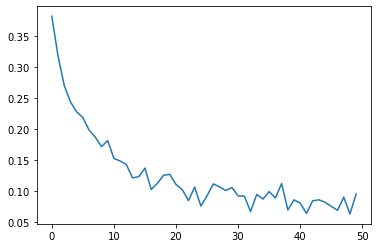

In [164]:
plt.plot(torch.tensor(lossi).view(-1, 10).mean(1))

In [165]:
model.eval()
t_predictions = []
t_targets = []
v_predictions = []
v_targets = []

threshold = 0.5

# Train Loss Calculations
with torch.no_grad():
    t_losses = []
    for inputs, labels in train_loader:
        outputs = model(inputs)
        # Version for averaging losses across batches
        loss = F.binary_cross_entropy_with_logits(outputs, labels)
        t_losses.append(loss)
        # Version for getting every loss individually
#         loss = F.binary_cross_entropy_with_logits(outputs, labels, reduction='none')
#         for idx in range(loss.shape[0]):
#             t_losses.append(loss[idx].mean())
        t_predictions.append(F.sigmoid(outputs).numpy())
        t_targets.append(labels.numpy())
        
train_avg_loss = np.array(t_losses).mean()
print("Train Loss:", train_avg_loss)

t_predictions = np.vstack(t_predictions)
t_targets = np.vstack(t_targets)

# Binary classification metrics
train_accuracy = metrics.accuracy_score(t_targets, (t_predictions > threshold).astype(int))
train_precision = metrics.precision_score(t_targets, (t_predictions > threshold).astype(int), average='samples', zero_division=0)
train_recall = metrics.recall_score(t_targets, (t_predictions > threshold).astype(int), average='samples')
train_f1 = metrics.f1_score(t_targets, (t_predictions > threshold).astype(int), average='samples')
train_roc_auc = metrics.roc_auc_score(t_targets, t_predictions, average='samples')

print(f'Accuracy: {train_accuracy:.4f}')
print(f'Precision: {train_precision:.4f}')
print(f'Recall: {train_recall:.4f}')
print(f'F1-score: {train_f1:.4f}')
print(f'ROC AUC: {train_roc_auc:.4f}')
print()

# Validation Loss Calculations
with torch.no_grad():
    v_losses = []
    for inputs, labels in val_loader:
        outputs = model(inputs)
        # Version for averaging losses across batches
        loss = F.binary_cross_entropy_with_logits(outputs, labels)
        v_losses.append(loss)
        # Version for getting every loss individually
#         loss = F.binary_cross_entropy_with_logits(outputs, labels, reduction='none')
#         for idx in range(loss.shape[0]):
#             v_losses.append(loss[idx].mean())
        v_predictions.append(F.sigmoid(outputs).numpy())
        v_targets.append(labels.numpy())
        
val_avg_loss = np.array(v_losses).mean()
print("Val Loss:", val_avg_loss)

v_predictions = np.vstack(v_predictions)
v_targets = np.vstack(v_targets)

# Binary classification metrics
#accuracy1 = accuracy_score(targets[:,1], (predictions[:,1] > 0.5).astype(int))
#precision1 = precision_score(targets[:,0], (predictions[:,0] > 0.5).astype(int))
accuracy = metrics.accuracy_score(v_targets, (v_predictions > threshold).astype(int))
precision = metrics.precision_score(v_targets, (v_predictions > threshold).astype(int), average='samples', zero_division=0)
recall = metrics.recall_score(v_targets, (v_predictions > threshold).astype(int), average='samples')
f1 = metrics.f1_score(v_targets, (v_predictions > threshold).astype(int), average='samples')
roc_auc = metrics.roc_auc_score(v_targets, v_predictions, average='samples')

#print(f'Accuracy1: {accuracy1:.4f}')
#print(f'Precision1: {precision1:.4f}')
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1:.4f}')
print(f'ROC AUC: {roc_auc:.4f}')

Train Loss: 0.023638004
Accuracy: 0.9146
Precision: 0.9657
Recall: 0.9554
F1-score: 0.9578
ROC AUC: 0.9898

Val Loss: 0.53249025
Accuracy: 0.0682
Precision: 0.5118
Recall: 0.4534
F1-score: 0.4519
ROC AUC: 0.8217


In [104]:
v_targets.sum(axis=0)

array([140., 107.,  67.,  81., 221., 155.,  68., 446.,  21.,  38.,  43.,
        34.,  25.,  77.,  77.,  28.,  15.,  86.,  19.], dtype=float32)

In [166]:
(v_predictions > 0.5).sum(axis=0)

array([117,  84,  52,  75, 217, 121,  68, 379,  21,  29,  29,  20,  18,
        54,  81,  11,  12,  45,   8])

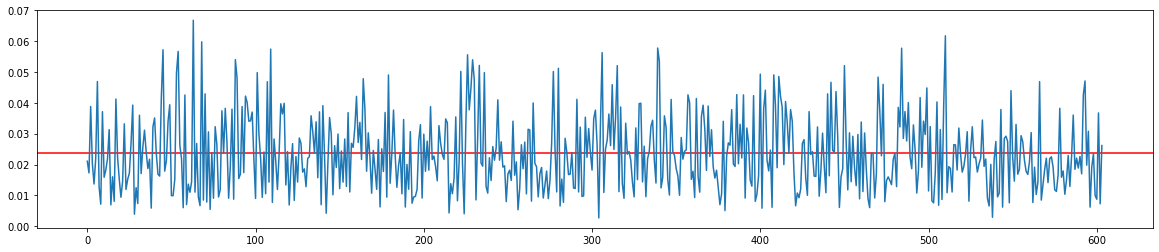

In [167]:
# For plotting train losses
plt.figure(figsize=(20,4))
plt.axhline(y = train_avg_loss, color = 'r', linestyle = '-') 
plt.plot(t_losses)

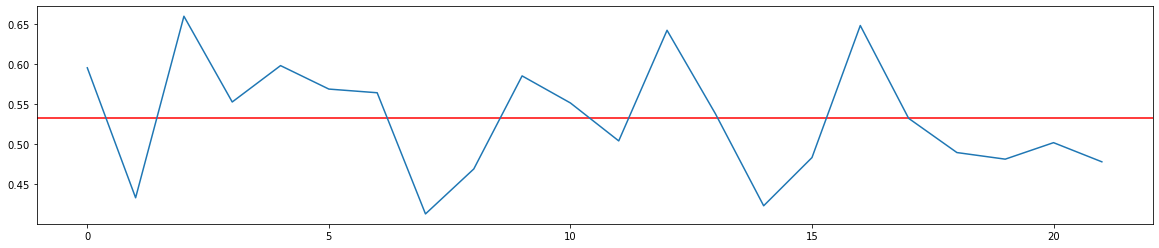

In [168]:
# For plotting val losses
plt.figure(figsize=(20,4))
plt.axhline(y = val_avg_loss, color = 'r', linestyle = '-') 
plt.plot(v_losses)

layer 0 ( RelU 0): mean +0.43, std 0.53, saturated: 51.04%
layer 1 ( RelU 1): mean +1.15, std 1.26, saturated: 41.33%


Text(0.5, 1.0, 'activation distribution')

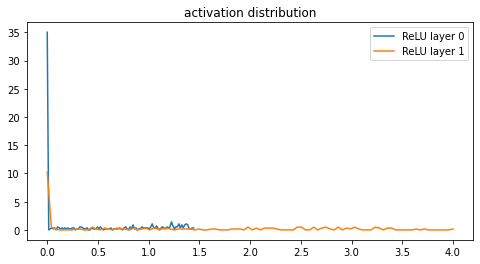

In [169]:
# Visualize Activation Distribution
plt.figure(figsize=(8, 4)) # width and height of the plot
legends = []
for i, output in enumerate(last_relu_outputs):
    t = output
    print('layer %d (%7s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, "RelU " + str(i), t.mean(), t.std(), (t == 0).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'ReLU layer {i}')
plt.legend(legends)
plt.title('activation distribution')

layer 0 (    RelU 0): mean -0.000000, std 3.988750e-03
layer 1 (    RelU 1): mean +0.000134, std 1.775159e-03


Text(0.5, 1.0, 'gradient distribution')

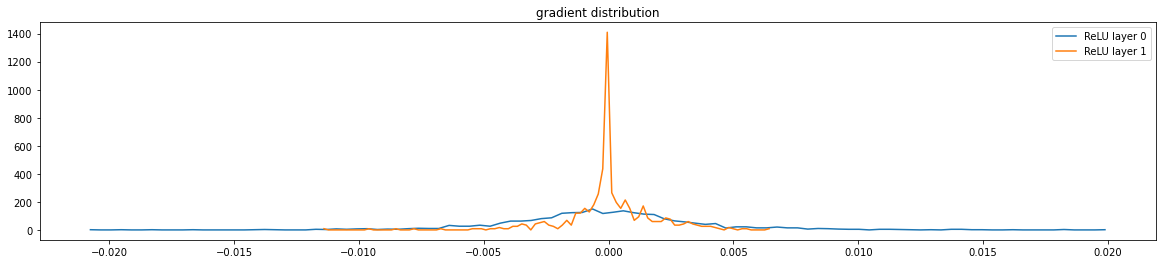

In [170]:
# Visualize Gradient Distribution
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, output in enumerate(last_relu_grads):
    t = output
    print('layer %d (%10s): mean %+f, std %e' % (i, "RelU " + str(i), t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    #hy /= hy.sum() # normalize, not sure about adding this yet. For consistency I'm leaving it out, may add later.
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'ReLU layer {i}')
plt.legend(legends);
plt.title('gradient distribution')

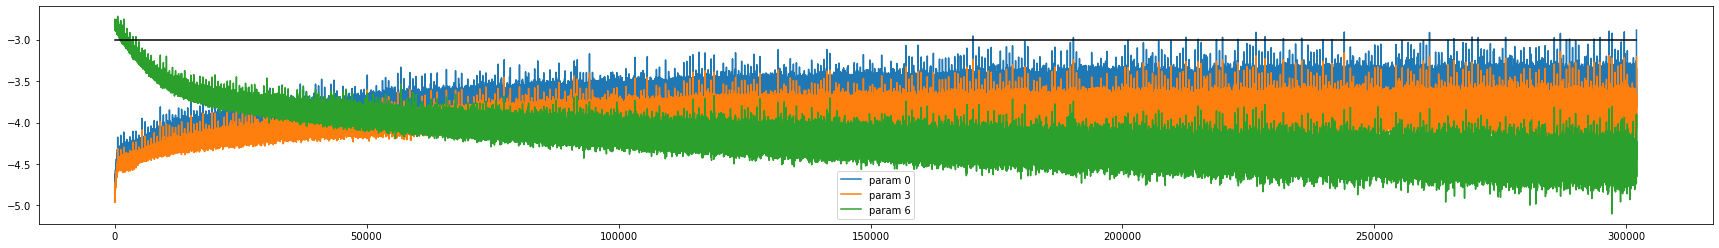

In [171]:
# Visualize Update-to-Data Ratio
plt.figure(figsize=(30, 4))
legends = []
for i,p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

## Results Log
#### Model 1
- SGD: 0.01   Epochs: 1000 Params: 57K Data: Original
    - Train Loss: 0.0633 
    - Val Loss: 0.4085
    - Accuracy: 0.1065
    - Precision: 0.5926
    - Recall: 0.5211
    - F1-score: 0.5216
    - ROC AUC: 0.8573

#### Model 2
- SGD: 0.01   Epochs: 1500 Params: 57K Data: Original
    - Train Loss: 0.0459
    - Val Loss: 0.5253
    - Accuracy: 0.0980
    - Precision: 0.5643
    - Recall: 0.5062
    - F1-score: 0.5028
    - ROC AUC: 0.8472

#### Model 3
Same parameters as model 1, except that I made the last layer less confident. Seems to have helped a lot with unseen data

- SGD: 0.01 Epochs: 1000 Params: 57K Data: Original
    - Train Loss: 0.06152942
    - Accuracy: 0.7614
    - Precision: 0.9693
    - Recall: 0.9069
    - F1-score: 0.9262
    - ROC AUC: 0.9907
    - -------------------
    - Val Loss: 0.36918175
    - Accuracy: 0.1222
    - Precision: 0.6038
    - Recall: 0.5258
    - F1-score: 0.5280
    - ROC AUC: 0.8643

#### Model 4
Same parameters as model 1 and 3, however, I've now implemented class weights to assign higher loss to underrepresented genres. The train loss scale has changed so it's no longer comparable to the other models, however, val loss is still comparable. Ran this setup a second time and it did not overfit as you can see below. Admittedly, I'm curious what happens if we try to push this further.

- SGD: 0.01 Epochs: 1000 Params: 57K Data: Original Regularizers: Class weights
    - Train Loss: 0.30083278
    - Accuracy: 0.0748
    - Precision: 0.6650
    - Recall: 0.3014
    - F1-score: 0.3997
    - ROC AUC: 0.8143
    - -------------------
    - Val Loss: 0.29794815
    - Accuracy: 0.0824
    - Precision: 0.6776
    - Recall: 0.3101
    - F1-score: 0.4093
    - ROC AUC: 0.8195

#### Model 5
First, off this thing is getting too long, I need to stop copying over all the images. After toying around with class weights for a little while I wasn't too convinced on their performance, I may circle back later. I decided to try out random oversampling. The basic rule I followed was to get the count of every genre up to at least 1000. Now the smallest class makes up roughly 7% of the dataset as opposed to 2% prior to the resampling.

I was rather amazed by the performance, although I do think many of the neurons were dead. I'm suspecting that the LR is too aggressive so now I'm going to rerun and lower the LR and bump up the epochs.

- SGD: 0.01 Epochs: 500 Params: 57K Data: Oversampled
    - Val Loss: 0.14914916 *
    - Accuracy: 0.5661
    - Precision: 0.8334
    - Recall: 0.8006
    - F1-score: 0.7984
    - ROC AUC: 0.9495
    
#### Model 5A
Same standard model with the oversampled dataset, but this time with Adam optimizer. Results improved a lot which is great, but not happy with the gradient distributions, and the training loss was all over the place. Going to now rerun adam with the original dataset just to see how the loss looks.

- Adam: 0.0003 Epochs: 1000 Params: 57K Data: Oversampled
    - Val Loss: 0.3212718
    - Accuracy: 0.6797 * 
    - Precision: 0.8522 *
    - Recall: 0.8477 *
    - F1-score: 0.8341 *
    - ROC AUC: 0.9526
    
#### Model 6
Successfully overfit the original dataset using Adam. Now that I've successfully overfit it with this setup, I'll regularize and see how much tradeoff we can get between giving up train loss to improve the val loss. Not happy with the gradient distributions though, still unlcear to me what this represents. I'm hoping that through regularizing this model it will fix the gradient distributions and also improve the results.

- Adam: 0.0003 Epochs: 1000 Params: 57K Data: Original
    - Train Loss: 0.00890103
    - Accuracy: 0.9743
    - Precision: 0.9888
    - Recall: 0.9807
    - F1-score: 0.9828
    - ROC AUC: 0.9947
    - -------------------
    - Val Loss: 1.0502023
    - Accuracy: 0.0852
    - Precision: 0.5669
    - Recall: 0.5099
    - F1-score: 0.5035
    - ROC AUC: 0.8557
    
#### Model 7
Through iterating on model 4 a couple times I've noticed that the class weights aren't doing nothing, it just takes a significiantly longer time to train. Since this model with Adam is converging pretty quickly I'm going to implement the class weights with the Adam model for an initial test run.

- Adam: 0.0003 Epochs: 1000 Params: 57K Data: Original Regularizers: Class weights
    - Train Loss: 0.01313037
    - Accuracy: 0.9510
    - Precision: 0.9820
    - Recall: 0.9790
    - F1-score: 0.9775
    - ROC AUC: 0.9945
    - -------------------
    - Val Loss: 1.0087472
    - Accuracy: 0.0980
    - Precision: 0.5656
    - Recall: 0.5289
    - F1-score: 0.5141
    - ROC AUC: 0.8612

Still overfit despite the addition of class weights. I've also been reading online that oversampling and class weights is a fairly similar idea in principle.

#### Model 8

- Adam: 0.0003 Epochs: 1000 Params: 57K Data: Oversampled Regularizers: Class weights
    - Train Loss: 0.010586039
    - Accuracy: 0.9683
    - Precision: 0.9864
    - Recall: 0.9797
    - F1-score: 0.9811
    - ROC AUC: 0.9932
    - -------------------
    - Val Loss: 0.29428375
    - Accuracy: 0.6783
    - Precision: 0.8455
    - Recall: 0.8475
    - F1-score: 0.8315
    - ROC AUC: 0.9566 *
    
Not quite as effective as I thought, but I've also been reading online that oversampling and class weights is a fairly similar idea in principle. That somewhat checks out as this model's performance is essentially identical to model 5A which all the same as this except no class weights were used. In fact, this model actually performs very very slightly worse than 5A in all of my metrics.

#### Model 9
Now I want to introduce weight decay. Going to start out with the vanilla AdamW optimizer.

- AdamW: 0.0003 Epochs: 1000 Params: 57K Data: Oversampled Regularizer: Weight decay(0.01)
    - Train Loss: 0.00957324
    - Accuracy: 0.9742
    - Precision: 0.9877
    - Recall: 0.9807
    - F1-score: 0.9824
    - ROC AUC: 0.9931
    - -------------------
    - Val Loss: 0.2504797
    - Accuracy: 0.6790
    - Precision: 0.8420
    - Recall: 0.8384
    - F1-score: 0.8254
    - ROC AUC: 0.9507
    
Again essentially identical performance to the current best model (5A) as well as (8) so now we have three models at essentially identical performance in different ways. All are on the oversampled dataset, however, weight decay and class weights has no helped to decrease train loss and increase val loss as the model without both of them (5A) has the best metrics.

#### Model 9A

- AdamW: 0.0003 Epochs: 1000 Params: 57K Data: Oversampled Regularizer: Weight decay(0.1)
    - Train Loss: 0.0153279435
    - Accuracy: 0.9652
    - Precision: 0.9857
    - Recall: 0.9794
    - F1-score: 0.9803
    - ROC AUC: 0.9929
    - -------------------
    - Val Loss: 0.16988453
    - Accuracy: 0.6776
    - Precision: 0.8477
    - Recall: 0.8471
    - F1-score: 0.8323
    - ROC AUC: 0.9462

#### Model 9B

This was more of an attempt to just push in the incorrect direction to assure myself things are working properly. A weight decay of this high is unrealistic, however, it didn't fully overfit and that was the goal.

- AdamW: 0.0003 Epochs: 1000 Params: 57K Data: Oversampled Regularizer: Weight decay(0.8)
    - Train Loss: 0.0671329
    - Accuracy: 0.7896
    - Precision: 0.9548
    - Recall: 0.9134
    - F1-score: 0.9251
    - ROC AUC: 0.9905
    - -------------------
    - Val Loss: 0.12983623
    - Accuracy: 0.5647
    - Precision: 0.8434
    - Recall: 0.7796
    - F1-score: 0.7918
    - ROC AUC: 0.9532
    
Kind of stuck here to be honest, I know that something is off based on the gradient distributions and the fact that I have models that are overfitting but then also performing half decent on validation sets. Haven't quite figured out the issue yet.

#### Model 10

Going to backtrack a little here. Previously the first initial signs of success were on the oversampled dataset with vanilla SGD. This model will be the oversampled dataset with nesterov momentum.
    
- SGD: 0.01 Nest_Momen: 0.9 Epochs: 500 Params: 57K Data: Oversampled
    - Train Loss: 0.009040079
    - Accuracy: 0.9748
    - Precision: 0.9756
    - Recall: 0.9754
    - F1-score: 0.9755
    - ROC AUC: 0.9932
    - -------------------
    - Val Loss: 0.30176982
    - Accuracy: 0.6715
    - Precision: 0.8220
    - Recall: 0.8201
    - F1-score: 0.8082
    - ROC AUC: 0.9462
    
This is an improvement upon the vanilla sgd model (5), still overfitting the training set.

#### Model 10A

Same as 10 but adding weight decay.

- SGD: 0.01 Nest_Momen: 0.9 Epochs: 500 Params: 57K Data: Oversampled Regularizer: Weight decay(0.01)
    - Train Loss: 0.28070715
    - Accuracy: 0.0453
    - Precision: 0.7822
    - Recall: 0.3467
    - F1-score: 0.4658
    - ROC AUC: 0.9001
    - -------------------
    - Val Loss: 0.28742668
    - Accuracy: 0.0507
    - Precision: 0.7582
    - Recall: 0.3407
    - F1-score: 0.4535
    - ROC AUC: 0.8793

Not ideal, training is fluctuating a ton. Going to lowering the learning rate.

#### Model 11

Back to model 3 setup, but wanted to overfit so trained for 2K epochs.

- SGD: 0.01 Epochs: 2000 Params: 57K Data: Original
    - Train Loss: 0.016619338
    - Accuracy: 0.9698
    - Precision: 0.9886
    - Recall: 0.9795
    - F1-score: 0.9819
    - ROC AUC: 0.9941
    - -------------------
    - Val Loss: 0.602286
    - Accuracy: 0.0980
    - Precision: 0.5531
    - Recall: 0.5095
    - F1-score: 0.4963
    - ROC AUC: 0.8370
    
#### Model 12
Created a new oversampled dataset that focused on not oversaturating the 'Drama' genre which was originally pretty top-heavy. 
- SGD: 0.01 Epochs: 500 Params: 57K Data: Oversampled v2

#### What's next?
Ok so admittedly, I've been running in circles getting nowhere. This is where things currently stand: 

- I have a poorly constructed oversampled dataset that when trained in multiple ways will overfit but still have relatively good performance on the val set. I've tried regularizing in a variety of ways but nothing seems to be improving the accuracy past 67% (also curious if this 67% represents some subset that it's always guessing, I'll need to look further into validation result counts to check this theory)
- I have the original dataset which I've overfit with Adam, but haven't achieved an accuracy above 12% with anything I've tried (Adam, SGD, class weights)
- I'm seeing two possible paths forward, focus on the original set once I've confirmed the overfitting in all scenarios and attempt to regularize it. Or construct a well-crafted oversampled set as this is where we've achieved the best results so far (and that version was poorly constructed, so maybe with some extra thought I can get it balancing the data more effectively)
- Side note: I want to start analyzing validation prediction stats on all the results after training sessions.

#### To-Do
- [ ] Regularize overfit model (Adam)
- [ ] Train model 4 for 8K epochs
- [ ] Finish step 2 check list
- [x] Train run with a smaller learning rate
- [x] Remove duplicates
- [x] Check for duplicates in columns other than primaryTitle
- [x] Calculate my personal accuracy on genre classification (YIKES)
- [x] Look into removing rows with descriptions that are too short.

#### Maybe in the future
- [ ] Stratified training
- [ ] Look deeper into titles with Animation genre, is there any textual evidence to determine animation? that might be visual only so I should remove the genre, perhaps a similar issue with the Biography genre.
- [ ] See where we can get with pushing the original model with sgd to overfitting. I've successfully overfit with Adam, but I'm curious if I'd be able to accomplish this with sgd, although this is kind of a pointless thing more so just curious. Maybe instead of just super vanilla sgd I use the nesterov version instead. Probably a future thing if I ever end up getting to this.

In [1561]:
for i, output in enumerate(last_relu_grads):
    t = output.shape
    print(t)

torch.Size([2, 128])
torch.Size([2, 50])


In [576]:
for i, layer in enumerate(model.parameters()): # note: exclude the output layer
    print(layer.shape)
    if isinstance(layer, torch.nn.modules.activation.ReLU):
        t = layer.grad
        print(t)

torch.Size([128, 384])
torch.Size([128])
torch.Size([128])
torch.Size([50, 128])
torch.Size([50])
torch.Size([50])
torch.Size([26, 50])


In [ ]:
### Alternate graphing of gradient distribution ###
# Assuming you have a list of gradient tensors 'last_relu_grads' for specific ReLU layers

# Create subplots for each ReLU layer
plt.figure(figsize=(20, 4 * len(last_relu_grads)))
legends = []

for i, output in enumerate(last_relu_grads):
    t = output

    # Calculate mean and standard deviation
    mean = t.mean().item()
    std = t.std().item()

    # Convert the PyTorch tensor to a NumPy array for histogram
    t_np = t.detach().numpy()

    # Create histogram
    n_bins = 50  # Adjust the number of bins as needed
    hist, bin_edges = np.histogram(t_np, bins=n_bins, density=True)

    # Normalize the histogram to represent probability density
    hist /= np.sum(hist)

    # Create the plot
    plt.plot(bin_edges[:-1], hist, label=f'ReLU layer {i}, mean={mean:.4f}, std={std:.4e}')

    legends.append(f'ReLU layer {i}')

plt.legend()
plt.title('Gradient Distribution with KDE')
plt.xlabel('Gradient Value')
plt.ylabel('Probability Density')
plt.show()

In [3]:
sent_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-V2')

enc1 = sent_model.encode("Tom Cruise's mother is Mary Lee Pfeiffer.")
print(enc1.shape)

(384,)


In [5]:
enc2 = sent_model.encode("Mary Lee Pfeiffer's son is Tom Cruise.")

In [7]:
F.cosine_similarity(torch.from_numpy(enc1).unsqueeze(0), torch.from_numpy(enc2).unsqueeze(0), dim=1)

tensor([0.9154])